## Data augmentation

- Artificiellt skapar bilder
- Slumpmässigt:
    - rotera till en viss grad
    - translatera slumpmässigt
    - spegla
    - shear
    - ...

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

y_train = y_train.ravel()
y_test = y_test.ravel()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [64]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

print(f"{X_train.max()=}, {X_train.min()=}")

X_train.max()=1.0, X_train.min()=0.0


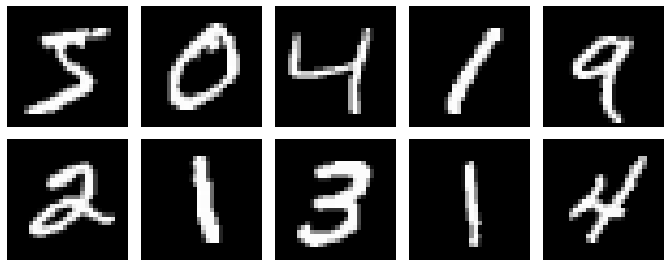

In [65]:
def display_images(data, nrows = 2, ncols = 5, figsize = (12,4)):
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i, :, :], cmap = "gray")
        ax.axis("off")

    fig.subplots_adjust(wspace = 0, hspace = .1, bottom = 0)

display_images(X_train)

In [66]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 1/6, random_state = 42)

X_train_val = X_train_val[:,:,:, None]
X_train = X_train[:,:,:, None]
X_val = X_val[:,:,:, None]
X_test = X_test[:,:,:, None]

X_train_val.shape

(50000, 28, 28, 1)

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    #rotation_range = 90,
    shear_range = .05,
    zoom_range = .1,
    #horizontal_flip = True,
    height_shift_range = .2,
    width_shift_range = .2
)

# don't augment valiadtion and test data

test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size = 32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size = 32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x296b23400>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x296b23550>)

In [71]:
print(len(train_val_generator.next()))
print(train_val_generator.next()[0].shape) # 32 samples in a batch

2
(32, 28, 28, 1)


[7 7 5 3 4 6 1 1 9 8]


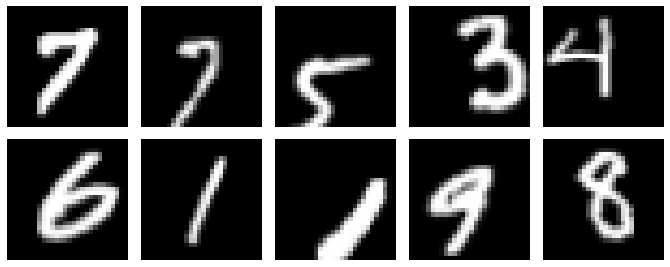

In [72]:
test = train_val_generator.next()

display_images(test[0])
print(test[1][:10])

CNN model

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = 0.001, drop_rate = 0.5, kernels = [32, 32]):
    adam = Adam(learning_rate = learning_rate)
    model = Sequential(name = "cnn_model")

    # Convolutional layers

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel, 
            kernel_size = (3, 3), 
            activation = "relu", 
            kernel_initializer = "he_normal",
            input_shape = X_train.shape[1:]
        )
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
    
    # MLP layers

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model(drop_rate = 0.5)
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0 